<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prelude" data-toc-modified-id="Prelude-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prelude</a></span></li><li><span><a href="#Utilities-(as-before)" data-toc-modified-id="Utilities-(as-before)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utilities (as before)</a></span></li><li><span><a href="#Finding-Shortest-Path-(as-before)" data-toc-modified-id="Finding-Shortest-Path-(as-before)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Finding Shortest Path (as before)</a></span></li><li><span><a href="#Finding-Shortest-Delivery-Route-(as-before)" data-toc-modified-id="Finding-Shortest-Delivery-Route-(as-before)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finding Shortest Delivery Route (as before)</a></span></li><li><span><a href="#Time-Handling" data-toc-modified-id="Time-Handling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Time Handling</a></span></li><li><span><a href="#Class-Recorder" data-toc-modified-id="Class-Recorder-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Class Recorder</a></span></li><li><span><a href="#Class-Parcel" data-toc-modified-id="Class-Parcel-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Class Parcel</a></span></li><li><span><a href="#Class-Customer" data-toc-modified-id="Class-Customer-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Class Customer</a></span></li><li><span><a href="#Class-Driver" data-toc-modified-id="Class-Driver-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Class Driver</a></span></li><li><span><a href="#Class-Delivery-Centre" data-toc-modified-id="Class-Delivery-Centre-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Class Delivery Centre</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Parameters-from-Specification" data-toc-modified-id="Parameters-from-Specification-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Parameters from Specification</a></span></li><li><span><a href="#Generate-Input-Data" data-toc-modified-id="Generate-Input-Data-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Generate Input Data</a></span></li><li><span><a href="#Simulation-Routine" data-toc-modified-id="Simulation-Routine-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>Simulation Routine</a></span></li><li><span><a href="#Model-Verification" data-toc-modified-id="Model-Verification-11.4"><span class="toc-item-num">11.4&nbsp;&nbsp;</span>Model Verification</a></span></li><li><span><a href="#Adding-Statistics-and-Visualisation" data-toc-modified-id="Adding-Statistics-and-Visualisation-11.5"><span class="toc-item-num">11.5&nbsp;&nbsp;</span>Adding Statistics and Visualisation</a></span></li></ul></li></ul></div>

# Prelude

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pulp
import math
import random
import pandas as pd
import numpy as np
import simpy

# Utilities (as before)

In [2]:
resolution = 10000  # city of about 10km diameter

In [3]:
def plotMap(G, T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=7,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    plt.xlim(0,resolution)
    plt.ylim(0,resolution)
    if not grid:
        plt.axis('off')
    V, E = G
    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if text is not None:
        plt.text(0.8*resolution, 0, text)
    if grid:
        plt.grid()
    plt.show()

# Finding Shortest Path (as before)

In [4]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

In [5]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [6]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

# Finding Shortest Delivery Route (as before)

In [7]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

In [8]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

def createLoop(M, T):
    D, P = createTables(M, T)
    # Matrix of the shortest path between every two points.
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):# The location of the customer is entered only once.
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):# The location of the customer is left only once.
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):# prevent subtour
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    # print(f"{constraints:d} Constraints")
    prob.solve(solver)
    trips = roundtrips(x, n)
    while len(trips)>1:
        for t in trips:
            prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                            for i in range(0,len(t)-1) ]) <= len(t)-2
            constraints += 1
        # print(f"{constraints:d} Constraints")
        prob.solve(solver)
        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
    return loop

# Time Handling

**Convention:** In this project we measure time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [9]:
    def timestamp(t):
        day = int(t)//(24*3600)
        t = t - day*24*3600
        hour = int(t)//3600
        t = t - hour*3600
        mins = int(t)//60
        t = t - mins*60
        secs = int(t)
        t = int(round((t - secs)*10))
        return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [10]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.1'

In [11]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

In [12]:
def day(now):
    return int(now//(24*3600))

# Class Recorder

We willl use a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder. 

In [13]:
class Recorder:
    
    def __init__(self, env, M, W, C, days, 
                 log=False, plot=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.log = log
        self.plot = plot
        Customer.REGISTER = []
        Parcel.REGISTER = []
        
        # create a data frame for time records per working day
        self.daily = pd.DataFrame()
        self.daily['driver_starts'] = [None]*days # The time of the driver starts to work per day
        self.daily['driver_ends'] = [None]*days # The time of the driver ends work per day
        self.daily['distance'] = [None]*days # The route distance per day
        self.daily['leftover'] = [None]*days # The number of leftover parcels per day
        
        # create a data frame for time records per parcel
        self.perParcel = pd.DataFrame()
        self.perParcel['arrived'] = [None]*len(Parcel.REGISTER) # The time of the parcel arrived at DC
        self.perParcel['accepted'] = [None]*len(Parcel.REGISTER) # The time of the parcel be accepted
        
    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)
            
    def recordTourLength(self, length):
        self.daily.at[day(self.env.now), 'distance'] = length/1000
        
    def recordLeftover(self, n):
        self.daily.at[day(self.env.now), 'leftover'] = int(n)
        
    def recordDriverBeginsWork(self):
        #self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'driver_starts'] = int(round(self.env.now))
        
    def recordDriverEndsWork(self):
        #self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'driver_ends'] = int(round(self.env.now))
    
    def recordParcelArrived(self,index):
        #self.trace("Parcel has been arrived:")
        self.perParcel.at[index, 'arrived'] = day(self.env.now)
        
    def recordCustomerAccepted(self,index):
        #self.trace("Parcel has been accepted by the customer")
        self.perParcel.at[index, 'accepted'] = day(self.env.now)
        
    def finish(self):
        self.daily['time'] = (self.daily['driver_ends']-self.daily['driver_starts'])/60
        self.perParcel['delay'] = self.perParcel['accepted']-self.perParcel['arrived']

# Class Parcel

<img src='EventGraph Parcel.png' width=500/>

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery 
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [14]:
class Parcel:
    
    REGISTER = []
    
    def __init__(self, rec, i, cust):
        self.rec = rec
        self.i = i  # row index in data frames of input data
        self.dest = cust.location
        self.status = [ 'processing' ] # status record and
        self.timing = [ self.rec.env.now ]      # timing
        assert(len(Parcel.REGISTER)==i)
        Parcel.REGISTER += [ self ] 
    
    # factory method ensures that there is only
    # one Parcel per location
    def getParcel(rec, i, location):
        for p in Parcel.REGISTER:
            if p.i == i:
                return p
        return Parcel(rec, i, location)

    
    def __str__(self):
        return f"Parcel: {self.i:2d}"

    def index(self):
        return self.i
    
    def destination(self):
        return self.dest
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        ###parcel arrived at DC time###
        self.rec.recordParcelArrived(self.i)
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')
    

# Class Customer

<img src='EventGraph Customer.png' width=500/>

In [15]:
class Customer:
    
    REGISTER = []

    def __init__(self, rec, location):
        self.rec = rec
        self.location = location
        self.i = len(Customer.REGISTER)
        Customer.REGISTER += [ self ]
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"
    
    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        return Customer(rec, location)
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        #self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        #self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self):
        if self.atHome:
            yield self.rec.env.timeout(random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR))
            #self.rec.trace(str(self)+" answers door")
            self.answersDoor = True
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            #self.rec(str(self)+" not at home")
            
    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        #self.rec.trace(str(self)+" accepts "+str(parcel))
        ###parcel accepted time###
        self.rec.recordCustomerAccepted(parcel.i)
            
    def signOff(self):
        assert(self.answersDoor)
        #self.rec.trace(str(self)+" signs off")
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))

# Class Driver

<img src='EventGraph Driver.png' width=500/>

In [16]:
class Driver:
    
    def __init__(self, rec, DC):
        self.rec = rec
        self.DC = DC
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        ###Driver Starts Work Time###
        self.rec.recordDriverBeginsWork()
        
    def leaveForDelivery(self, tour, parcels):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " \
                       f"of {len(parcels):d} parcels")
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
            ###Route Distance###
            self.rec.recordTourLength(pathLength(tour))
            self.leaveForDelivery(tour, parcels)
            
            while len(self.parcels)>0:
                # drive to customer
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to "+str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at "+str(cust))
                # call at customer
                yield from cust.answerDoor()
                
                if cust.answersDoor:
                    while len(self.parcels)>0 and \
                            custLocation == self.parcels[0].dest:
                        cust.acceptParcel(self.parcels[0])
                        yield self.rec.env.timeout(random.expovariate(1/10))
                        self.parcels = self.parcels[1:]
                    cust.signOff()
                    yield self.rec.env.timeout(random.expovariate(1/10))
                else:
                    while len(self.parcels)>0 and  \
                            custLocation == self.parcels[0].dest:
                        self.returns += self.parcels[0]
                        self.parcels = self.parcels[1:]

            # return to delivery centre
            self.rec.trace("Driver returns to delivery centre")
            yield from self.__drive(self.DC.W)
            self.rec.trace("Driver arrived at delivery centre")
            
            for parcel in self.returns:
                self.DC.returnFromDelivery(parcel)
                yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            yield self.rec.env.timeout(600)
            ###Driver Ends Work Time###
            self.rec.recordDriverEndsWork()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

# Class Delivery Centre

<img src="EventGraph Delivery Centre.png" width=300/>

In [17]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W):
        self.rec = rec
        self.M = M
        self.W = W
        self.limit = 30000
        
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = [W]       # tour planned for delivery
        
    def __accept(self, parcel):
        custLoc = parcel.dest
        if custLoc not in self.dest:
            S = createLoop(self.M, [self.W] + self.dest + [custLoc])
            if pathLength(S)<self.limit:
                self.parcels.append(parcel)
                self.dest += [custLoc]
                self.tour = S
            else:
                self.leftOver.append(parcel)
        else:
            self.parcels.append(parcel)
        
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        tour = self.tour
        addresses = self.dest
        
        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels:
                if p.dest == dest:
                    parcels += [p]
                    p.outForDelivery()
         
        # arrange the leftover
        L = self.leftOver
        ###LeftOver Parcels###
        self.rec.recordLeftover(len(L))
        #print(f"LeftOver {len(L):d} parcels")
        self.tour = [self.W]
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, w=tour[0], 
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels
                 
    def returnFromDelivery(self, parcel):
        parcel.returnFromDelivery()
        self.__accept(parcel)

# Simulation

## Parameters from Specification

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [18]:
AVERAGE_SPEED = 15/3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [19]:
PREP_TIME_PER_PARCEL = 50

**Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parce. 

In [20]:
RETURN_TIME_PER_PARCEL = 30

The average time to answer the door.

In [21]:
AVERAGE_TIME_ANSWER_DOOR = 40

In [22]:
WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

## Generate Input Data

In [23]:
def generateInputData(D):

    R = [ len(d) for d in D ]
    N = sum(R)
    
    DAY_LENGTH = 24*3600    # measured in minutes
    DAY_START = 8*3600      # first delivery in the morning
    DAY_END = 17*3600     # last delivery during day time

    IARR = (DAY_END-DAY_START-2*3600)*len(D) / N  # measured in minutes

    x = pd.DataFrame()

    x['iarr'] = [None]*N
    x['time'] = [None]*N
    x['day'] = [None]*N
    x['dest'] = [None]*N

    current_day = 0
    delivered_today = 0
    time = DAY_START
    last_time = 0

    for i in range(N):
    
        iat = random.expovariate(1.0/IARR)
        new_time = time + iat
    
        if delivered_today == len(D[current_day]):
            current_day += 1
            delivered_today = 0
            new_time = current_day*DAY_LENGTH + DAY_START + iat
        else:
            new_time = time + iat
    
        iat = new_time - last_time
        last_time = time = new_time
    
        x.at[i, 'iarr'] = round(iat,1)
        x.at[i, 'time'] = round(new_time - current_day*DAY_LENGTH , 1)
        x.at[i, 'day'] = current_day
        x.at[i, 'dest'] = D[current_day][delivered_today]
    
        delivered_today += 1
    
    return x

In [24]:
# plt.plot(x.time/60, 'o', ms=3)
# plt.vlines(x=np.cumsum(R)-0.5, ymin=7, ymax=24, color='red', lw=0.5)
# plt.hlines(y=[8,18], xmin=0, xmax=sum(R))

## Simulation Routine

In [25]:
def simulation(M, W, C, D, log=False, plot=False):
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, len(D), log=log, plot=plot)

    x = generateInputData(D)
    
    print(f"Simulating delivery of {len(x):d} parcels "
          f"over {len(D):d} days to {len(C):d} customers")

    def generatorProcess(env):
        
        for c in C:
            Customer.getCustomer(rec, c)           
        DC = DeliveryCentre(rec, M, W)
        D = Driver(rec, DC)
        
        # generate the parcels based on input data x
        for i in range(len(x)):
            yield env.timeout(x.at[i, 'iarr'])
            custLoc = C[x.at[i, 'dest']]
            cust = Customer.getCustomer(rec, custLoc)
            p = Parcel.getParcel(rec, i, cust)
            DC.acceptParcel(p)

    env.process(generatorProcess(env))
    env.run()
    rec.finish()   
    return rec

## Model Verification

In [26]:
import pickle
with open('data.17644.test1.1.pickled', 'rb') as f17:
    M17, W17, C17, D17 = pickle.load(f17)

Simulating delivery of 448 parcels over 22 days to 100 customers
[ 0] 08:38:22.5 Parcel:  0 arr at delivery centre
[ 0] 09:07:38.1 Parcel:  1 arr at delivery centre
[ 0] 09:18:53.4 Parcel:  2 arr at delivery centre
[ 0] 09:25:04.2 Parcel:  3 arr at delivery centre
[ 0] 09:39:50.2 Parcel:  4 arr at delivery centre
[ 0] 09:50:32.6 Parcel:  5 arr at delivery centre
[ 0] 10:22:07.9 Parcel:  6 arr at delivery centre
[ 0] 10:29:35.2 Parcel:  7 arr at delivery centre
[ 0] 10:42:56.4 Parcel:  8 arr at delivery centre
[ 0] 11:00:59.9 Parcel:  9 arr at delivery centre
[ 0] 11:50:14.1 Parcel: 10 arr at delivery centre
[ 0] 12:04:43.5 Parcel: 11 arr at delivery centre
[ 0] 12:11:33.2 Parcel: 12 arr at delivery centre
[ 0] 12:40:37.8 Parcel: 13 arr at delivery centre
[ 0] 13:00:29.9 Parcel: 14 arr at delivery centre
[ 0] 13:06:26.7 Parcel: 15 arr at delivery centre
[ 0] 13:56:03.0 Parcel: 16 arr at delivery centre
[ 0] 15:19:49.7 Parcel: 17 arr at delivery centre
[ 0] 15:54:06.3 Parcel: 18 arr at d

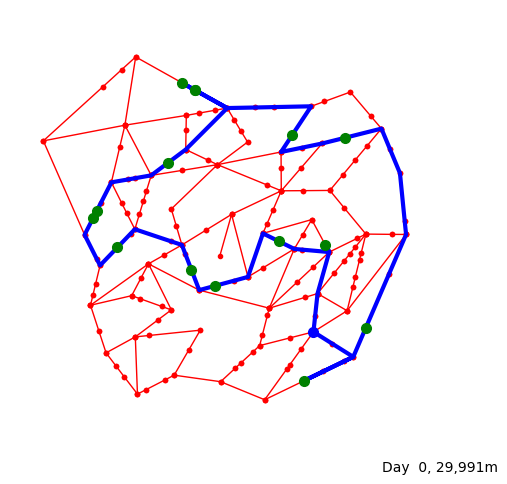

[ 0] 18:03:57.0 Parcel: 22 arr at delivery centre
[ 0] 18:14:10.0 Driver leaves for delivery of 17 parcels
[ 0] 18:14:10.0 Driver drives to Customer: 12 (6332, 1958)
[ 0] 18:22:52.10 Driver arrived at Customer: 12 (6332, 1958)
[ 0] 18:23:48.8 Driver drives to Customer: 15 (7647, 3089)
[ 0] 18:31:10.4 Driver arrived at Customer: 15 (7647, 3089)
[ 0] 18:33:28.4 Driver drives to Customer: 92 (7207, 7213)
[ 0] 18:55:01.8 Driver arrived at Customer: 92 (7207, 7213)
[ 0] 18:56:52.2 Driver drives to Customer: 45 (6075, 7281)
[ 0] 19:04:18.6 Driver arrived at Customer: 45 (6075, 7281)
[ 0] 19:05:05.4 Driver drives to Customer: 93 (3975, 8246)
[ 0] 19:18:26.0 Driver arrived at Customer: 93 (3975, 8246)
[ 0] 19:19:47.0 Driver drives to Customer: 29 (3699, 8402)
[ 0] 19:21:03.1 Driver arrived at Customer: 29 (3699, 8402)
[ 0] 19:21:43.8 Driver drives to Customer: 93 (3975, 8246)
[ 0] 19:22:59.8 Driver arrived at Customer: 93 (3975, 8246)
[ 0] 19:23:35.6 Driver drives to Customer:  0 (3403, 6675)


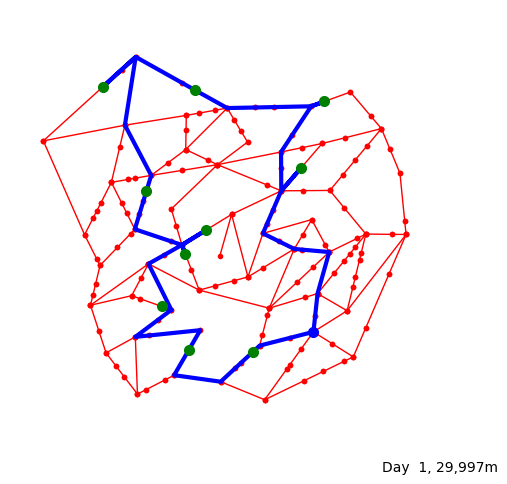

[ 1] 18:10:00.0 Driver leaves for delivery of 12 parcels
[ 1] 18:10:00.0 Driver drives to Customer: 13 (6261, 6563)
[ 1] 18:29:42.5 Driver arrived at Customer: 13 (6261, 6563)
[ 1] 18:32:07.2 Driver drives to Customer: 24 (6761, 7998)
[ 1] 18:44:02.1 Driver arrived at Customer: 24 (6761, 7998)
[ 1] 18:44:09.8 Driver drives to Customer: 93 (3975, 8246)
[ 1] 18:55:47.0 Driver arrived at Customer: 93 (3975, 8246)
[ 1] 18:56:40.8 Driver drives to Customer: 28 (2001, 8320)
[ 1] 19:06:19.5 Driver arrived at Customer: 28 (2001, 8320)
[ 1] 19:07:50.10 Driver drives to Customer: 46 (2934, 6061)
[ 1] 19:23:56.7 Driver arrived at Customer: 46 (2934, 6061)
[ 1] 19:24:19.5 Driver drives to Customer: 55 (3768, 4704)
[ 1] 19:32:50.7 Driver arrived at Customer: 55 (3768, 4704)
[ 1] 19:34:43.5 Driver drives to Customer:  3 (4210, 5211)
[ 1] 19:37:56.5 Driver arrived at Customer:  3 (4210, 5211)
[ 1] 19:38:24.4 Driver drives to Customer: 76 (3265, 3561)
[ 1] 19:49:25.9 Driver arrived at Customer: 76 (32

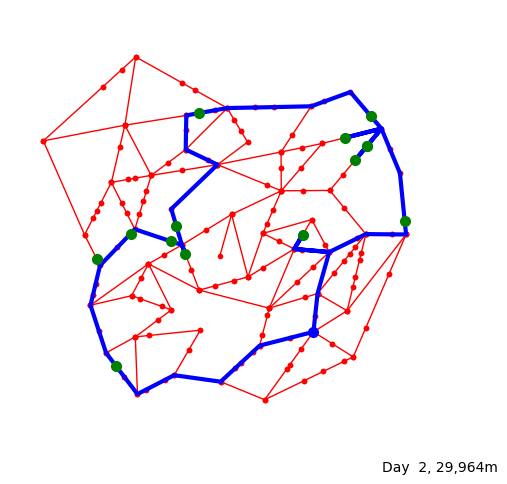

[ 2] 18:18:20.0 Driver leaves for delivery of 22 parcels
[ 2] 18:18:20.0 Driver drives to Customer:  6 (6292, 5109)
[ 2] 18:29:48.1 Driver arrived at Customer:  6 (6292, 5109)
[ 2] 18:32:57.8 Driver drives to Customer: 72 (8488, 5412)
[ 2] 18:45:31.2 Driver arrived at Customer: 72 (8488, 5412)
[ 2] 18:47:15.9 Driver drives to Customer: 92 (7207, 7213)
[ 2] 18:58:48.8 Driver arrived at Customer: 92 (7207, 7213)
[ 2] 18:59:20.8 Driver drives to Customer: 53 (7669, 7026)
[ 2] 19:04:33.7 Driver arrived at Customer: 53 (7669, 7026)
[ 2] 19:04:53.4 Driver drives to Customer: 50 (7428, 6736)
[ 2] 19:06:23.9 Driver arrived at Customer: 50 (7428, 6736)
[ 2] 19:06:30.6 Driver drives to Customer: 53 (7669, 7026)
[ 2] 19:08:01.1 Driver arrived at Customer: 53 (7669, 7026)
[ 2] 19:08:17.6 Driver drives to Customer: 77 (7757, 7684)
[ 2] 19:11:43.0 Driver arrived at Customer: 77 (7757, 7684)
[ 2] 19:12:44.0 Driver drives to Customer: 25 (4069, 7747)
[ 2] 19:28:42.1 Driver arrived at Customer: 25 (406

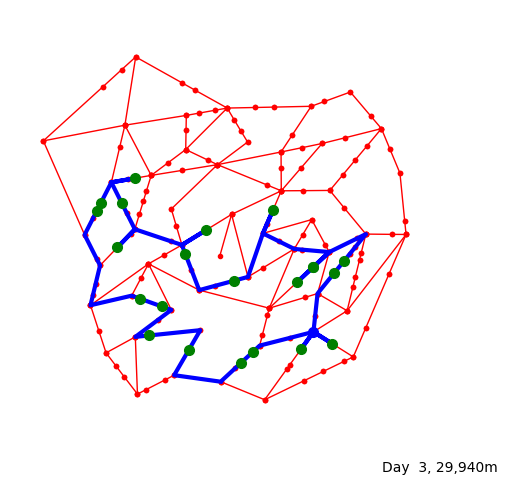

[ 3] 18:23:20.0 Driver leaves for delivery of 28 parcels
[ 3] 18:23:20.0 Driver drives to Customer: 34 (6926, 2758)
[ 3] 18:25:13.5 Driver arrived at Customer: 34 (6926, 2758)
[ 3] 18:27:11.9 Driver drives to Customer: 42 (6254, 2631)
[ 3] 18:30:57.8 Driver arrived at Customer: 42 (6254, 2631)
[ 3] 18:31:47.2 Driver drives to Customer: 31 (6977, 4291)
[ 3] 18:39:17.9 Driver arrived at Customer: 31 (6977, 4291)
[ 3] 18:39:39.6 Driver drives to Customer: 83 (7183, 4545)
[ 3] 18:40:58.1 Driver arrived at Customer: 83 (7183, 4545)
[ 3] 18:41:26.5 Driver drives to Customer: 54 (6519, 4413)
[ 3] 18:49:50.8 Driver arrived at Customer: 54 (6519, 4413)
[ 3] 18:50:36.2 Driver drives to Customer: 99 (6174, 4088)
[ 3] 18:52:29.8 Driver arrived at Customer: 99 (6174, 4088)
[ 3] 18:53:23.5 Driver drives to Customer: 54 (6519, 4413)
[ 3] 18:55:17.0 Driver arrived at Customer: 54 (6519, 4413)
[ 3] 18:56:59.1 Driver drives to Customer: 20 (5652, 5640)
[ 3] 19:07:04.1 Driver arrived at Customer: 20 (565

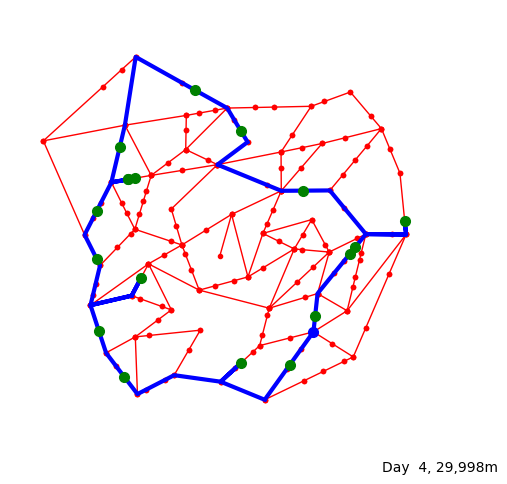

[ 4] 18:18:20.0 Driver leaves for delivery of 22 parcels
[ 4] 18:18:20.0 Driver drives to Customer: 95 (6018, 2300)
[ 4] 18:20:39.1 Parcel: 103 arr at delivery centre
[ 4] 18:21:49.8 Driver arrived at Customer: 95 (6018, 2300)
[ 4] 18:22:18.2 Driver drives to Customer: 39 (4968, 2341)
[ 4] 18:23:13.3 Parcel: 104 arr at delivery centre
[ 4] 18:32:30.7 Driver arrived at Customer: 39 (4968, 2341)
[ 4] 18:33:16.2 Driver drives to Customer: 65 (2455, 2041)
[ 4] 18:45:08.0 Driver arrived at Customer: 65 (2455, 2041)
[ 4] 18:46:43.4 Driver drives to Customer: 75 (1910, 3035)
[ 4] 18:51:18.7 Driver arrived at Customer: 75 (1910, 3035)
[ 4] 18:51:53.2 Driver drives to Customer: 10 (2820, 4183)
[ 4] 18:59:35.7 Driver arrived at Customer: 10 (2820, 4183)
[ 4] 19:00:40.10 Driver drives to Customer: 57 (1862, 4597)
[ 4] 19:10:16.0 Driver arrived at Customer: 57 (1862, 4597)
[ 4] 19:11:48.0 Driver drives to Customer:  1 (1868, 5634)
[ 4] 19:16:26.2 Driver arrived at Customer:  1 (1868, 5634)
[ 4] 19

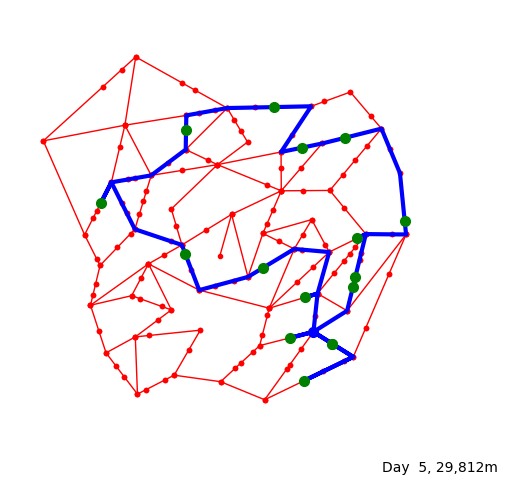

[ 5] 18:15:00.0 Driver leaves for delivery of 18 parcels
[ 5] 18:15:00.0 Driver drives to Customer: 34 (6926, 2758)
[ 5] 18:16:53.5 Driver arrived at Customer: 34 (6926, 2758)
[ 5] 18:18:27.10 Driver drives to Customer: 12 (6332, 1958)
[ 5] 18:25:17.4 Driver arrived at Customer: 12 (6332, 1958)
[ 5] 18:26:35.10 Driver drives to Customer: 34 (6926, 2758)
[ 5] 18:33:25.4 Driver arrived at Customer: 34 (6926, 2758)
[ 5] 18:36:22.10 Driver drives to Customer: 88 (6351, 3760)
[ 5] 18:42:42.2 Driver arrived at Customer: 88 (6351, 3760)
[ 5] 18:43:38.3 Driver drives to Customer: 89 (5445, 4400)
[ 5] 18:54:36.6 Driver arrived at Customer: 89 (5445, 4400)
[ 5] 18:54:51.2 Driver drives to Customer: 55 (3768, 4704)
[ 5] 19:04:05.9 Driver arrived at Customer: 55 (3768, 4704)
[ 5] 19:04:18.2 Driver drives to Customer: 97 (1952, 5799)
[ 5] 19:15:54.6 Driver arrived at Customer: 97 (1952, 5799)
[ 5] 19:17:43.1 Driver drives to Customer: 58 (3786, 7387)
[ 5] 19:28:38.1 Driver arrived at Customer: 58 (

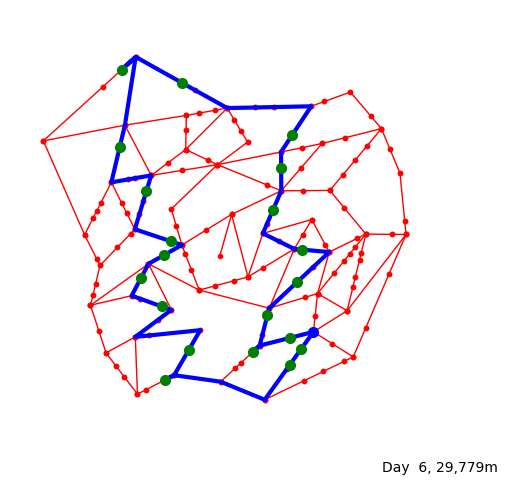

[ 6] 18:17:30.0 Driver leaves for delivery of 21 parcels
[ 6] 18:17:30.0 Driver drives to Customer: 42 (6254, 2631)
[ 6] 18:19:22.3 Driver arrived at Customer: 42 (6254, 2631)
[ 6] 18:20:30.9 Driver drives to Customer: 95 (6018, 2300)
[ 6] 18:22:08.4 Driver arrived at Customer: 95 (6018, 2300)
[ 6] 18:24:50.1 Driver drives to Customer: 14 (3334, 1972)
[ 6] 18:37:34.1 Driver arrived at Customer: 14 (3334, 1972)
[ 6] 18:37:52.10 Driver drives to Customer:  8 (3850, 2629)
[ 6] 18:41:19.4 Driver arrived at Customer:  8 (3850, 2629)
[ 6] 18:42:11.7 Driver drives to Customer: 76 (3265, 3561)
[ 6] 18:54:29.3 Driver arrived at Customer: 76 (3265, 3561)
[ 6] 18:54:52.1 Driver drives to Customer: 10 (2820, 4183)
[ 6] 18:59:22.1 Driver arrived at Customer: 10 (2820, 4183)
[ 6] 19:00:41.10 Driver drives to Customer: 26 (3315, 4675)
[ 6] 19:03:36.2 Driver arrived at Customer: 26 (3315, 4675)
[ 6] 19:04:29.4 Driver drives to Customer:  2 (3460, 4972)
[ 6] 19:07:14.5 Driver arrived at Customer:  2 (3

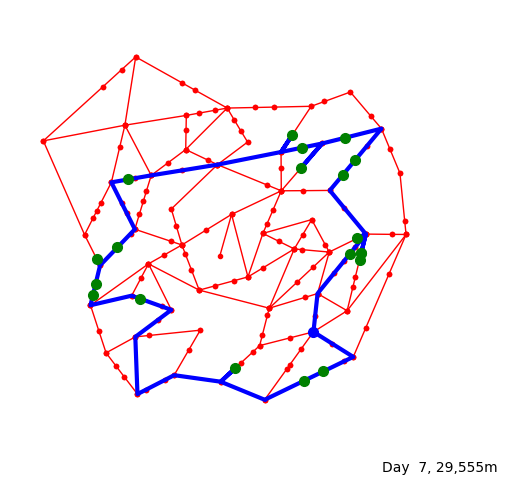

[ 7] 18:22:30.0 Driver leaves for delivery of 27 parcels
[ 7] 18:22:30.0 Driver drives to Customer: 81 (7308, 4700)
[ 7] 18:30:14.6 Driver arrived at Customer: 81 (7308, 4700)
[ 7] 18:30:50.8 Driver drives to Customer: 69 (7462, 5033)
[ 7] 18:33:53.7 Driver arrived at Customer: 69 (7462, 5033)
[ 7] 18:34:30.5 Driver drives to Customer: 85 (7554, 4725)
[ 7] 18:37:01.0 Driver arrived at Customer: 85 (7554, 4725)
[ 7] 18:38:06.3 Driver drives to Customer: 67 (7517, 4571)
[ 7] 18:38:44.2 Driver arrived at Customer: 67 (7517, 4571)
[ 7] 18:40:20.7 Driver drives to Customer: 85 (7554, 4725)
[ 7] 18:40:58.6 Driver arrived at Customer: 85 (7554, 4725)
[ 7] 18:42:18.7 Driver drives to Customer: 38 (7153, 6404)
[ 7] 18:50:34.3 Driver arrived at Customer: 38 (7153, 6404)
[ 7] 18:51:44.7 Driver drives to Customer: 50 (7428, 6736)
[ 7] 18:53:28.1 Driver arrived at Customer: 50 (7428, 6736)
[ 7] 18:54:32.0 Driver drives to Customer: 92 (7207, 7213)
[ 7] 19:01:15.5 Driver arrived at Customer: 92 (720

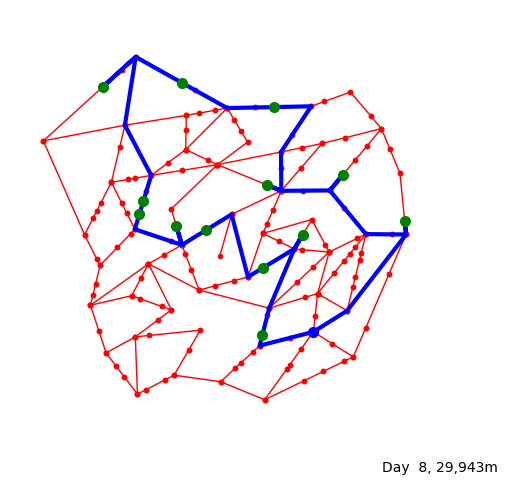

[ 8] 18:11:40.0 Driver leaves for delivery of 14 parcels
[ 8] 18:11:40.0 Driver drives to Customer: 72 (8488, 5412)
[ 8] 18:24:35.2 Driver arrived at Customer: 72 (8488, 5412)
[ 8] 18:27:28.6 Driver drives to Customer: 38 (7153, 6404)
[ 8] 18:38:42.7 Driver arrived at Customer: 38 (7153, 6404)
[ 8] 18:39:11.10 Driver drives to Customer: 36 (5535, 6188)
[ 8] 18:46:23.3 Driver arrived at Customer: 36 (5535, 6188)
[ 8] 18:47:36.2 Driver drives to Customer: 21 (5685, 7877)
[ 8] 19:00:09.1 Driver arrived at Customer: 21 (5685, 7877)
[ 8] 19:00:36.7 Driver drives to Customer: 29 (3699, 8402)
[ 8] 19:09:07.5 Driver arrived at Customer: 29 (3699, 8402)
[ 8] 19:10:02.7 Driver drives to Customer: 28 (2001, 8320)
[ 8] 19:18:25.2 Driver arrived at Customer: 28 (2001, 8320)
[ 8] 19:19:15.10 Driver drives to Customer: 44 (2868, 5841)
[ 8] 19:36:16.7 Driver arrived at Customer: 44 (2868, 5841)
[ 8] 19:36:42.7 Driver drives to Customer: 59 (2781, 5553)
[ 8] 19:37:54.7 Driver arrived at Customer: 59 (2

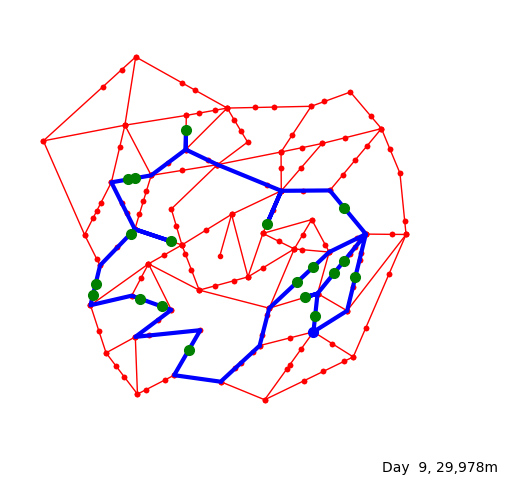

[ 9] 18:19:10.0 Driver leaves for delivery of 23 parcels
[ 9] 18:19:10.0 Driver drives to Customer: 91 (7426, 4198)
[ 9] 18:25:35.2 Driver arrived at Customer: 91 (7426, 4198)
[ 9] 18:26:21.7 Driver drives to Customer: 54 (6519, 4413)
[ 9] 18:35:35.6 Driver arrived at Customer: 54 (6519, 4413)
[ 9] 18:36:31.8 Driver drives to Customer: 99 (6174, 4088)
[ 9] 18:38:25.3 Driver arrived at Customer: 99 (6174, 4088)
[ 9] 18:39:45.3 Driver drives to Customer:  8 (3850, 2629)
[ 9] 18:57:33.1 Driver arrived at Customer:  8 (3850, 2629)
[ 9] 18:57:38.9 Driver drives to Customer: 76 (3265, 3561)
[ 9] 19:09:56.5 Driver arrived at Customer: 76 (3265, 3561)
[ 9] 19:10:10.1 Driver drives to Customer: 71 (2801, 3728)
[ 9] 19:12:08.4 Driver arrived at Customer: 71 (2801, 3728)
[ 9] 19:13:09.9 Driver drives to Customer: 62 (1784, 3809)
[ 9] 19:18:29.4 Driver arrived at Customer: 62 (1784, 3809)
[ 9] 19:19:05.2 Driver drives to Customer: 87 (1841, 4049)
[ 9] 19:20:04.2 Driver arrived at Customer: 87 (184

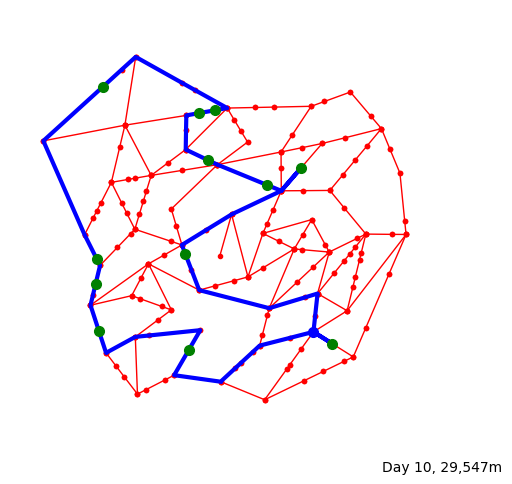

[10] 18:11:40.0 Driver leaves for delivery of 14 parcels
[10] 18:11:40.0 Driver drives to Customer: 34 (6926, 2758)
[10] 18:13:33.5 Driver arrived at Customer: 34 (6926, 2758)
[10] 18:15:53.5 Driver drives to Customer:  8 (3850, 2629)
[10] 18:33:44.1 Driver arrived at Customer:  8 (3850, 2629)
[10] 18:35:38.2 Driver drives to Customer: 75 (1910, 3035)
[10] 18:48:03.4 Driver arrived at Customer: 75 (1910, 3035)
[10] 18:48:06.7 Driver drives to Customer: 87 (1841, 4049)
[10] 18:52:19.7 Driver arrived at Customer: 87 (1841, 4049)
[10] 18:54:41.9 Driver drives to Customer: 57 (1862, 4597)
[10] 18:57:00.4 Driver arrived at Customer: 57 (1862, 4597)
[10] 18:59:29.8 Driver drives to Customer: 28 (2001, 8320)
[10] 19:17:37.7 Driver arrived at Customer: 28 (2001, 8320)
[10] 19:18:42.8 Driver drives to Customer:  7 (4400, 7807)
[10] 19:32:38.7 Driver arrived at Customer:  7 (4400, 7807)
[10] 19:33:32.6 Driver drives to Customer: 25 (4069, 7747)
[10] 19:34:53.2 Driver arrived at Customer: 25 (406

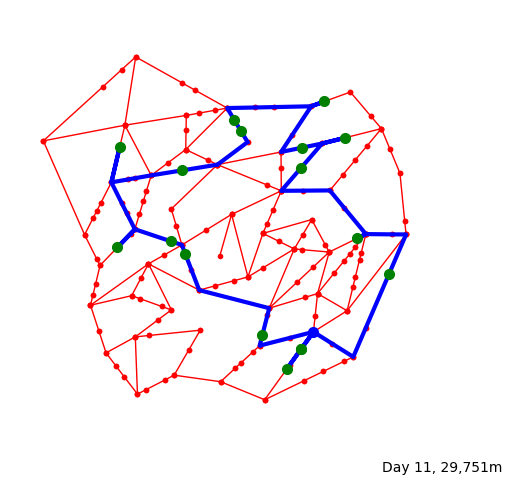

[11] 18:16:40.0 Driver leaves for delivery of 20 parcels
[11] 18:16:40.0 Driver drives to Customer: 42 (6254, 2631)
[11] 18:18:32.3 Driver arrived at Customer: 42 (6254, 2631)
[11] 18:19:52.9 Driver drives to Customer: 78 (5954, 2210)
[11] 18:21:56.8 Driver arrived at Customer: 78 (5954, 2210)
[11] 18:23:32.1 Driver drives to Customer: 42 (6254, 2631)
[11] 18:25:35.9 Driver arrived at Customer: 42 (6254, 2631)
[11] 18:26:43.9 Driver drives to Customer: 23 (5425, 2935)
[11] 18:34:17.3 Driver arrived at Customer: 23 (5425, 2935)
[11] 18:36:12.10 Driver drives to Customer: 55 (3768, 4704)
[11] 18:48:13.9 Driver arrived at Customer: 55 (3768, 4704)
[11] 18:50:26.9 Driver drives to Customer:  2 (3460, 4972)
[11] 18:52:14.9 Driver arrived at Customer:  2 (3460, 4972)
[11] 18:53:11.9 Driver drives to Customer: 66 (2311, 4841)
[11] 18:58:37.8 Driver arrived at Customer: 66 (2311, 4841)
[11] 18:59:14.3 Driver drives to Customer: 16 (2362, 7021)
[11] 19:09:06.4 Driver arrived at Customer: 16 (23

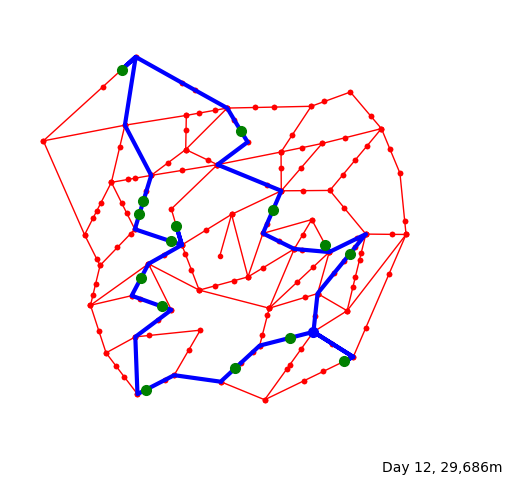

[12] 18:16:40.0 Driver leaves for delivery of 20 parcels
[12] 18:16:40.0 Driver drives to Customer: 81 (7308, 4700)
[12] 18:24:24.6 Driver arrived at Customer: 81 (7308, 4700)
[12] 18:25:39.1 Driver drives to Customer: 37 (6784, 4889)
[12] 18:32:02.4 Driver arrived at Customer: 37 (6784, 4889)
[12] 18:33:33.9 Driver drives to Customer: 20 (5652, 5640)
[12] 18:42:25.8 Driver arrived at Customer: 20 (5652, 5640)
[12] 18:43:50.4 Driver drives to Customer: 48 (4961, 7367)
[12] 18:56:01.4 Driver arrived at Customer: 48 (4961, 7367)
[12] 18:56:23.10 Driver drives to Customer: 52 (2403, 8689)
[12] 19:09:19.4 Driver arrived at Customer: 52 (2403, 8689)
[12] 19:09:57.7 Driver drives to Customer: 44 (2868, 5841)
[12] 19:24:47.6 Driver arrived at Customer: 44 (2868, 5841)
[12] 19:25:06.8 Driver drives to Customer: 59 (2781, 5553)
[12] 19:26:18.8 Driver arrived at Customer: 59 (2781, 5553)
[12] 19:26:31.8 Driver drives to Customer:  2 (3460, 4972)
[12] 19:31:08.0 Driver arrived at Customer:  2 (34

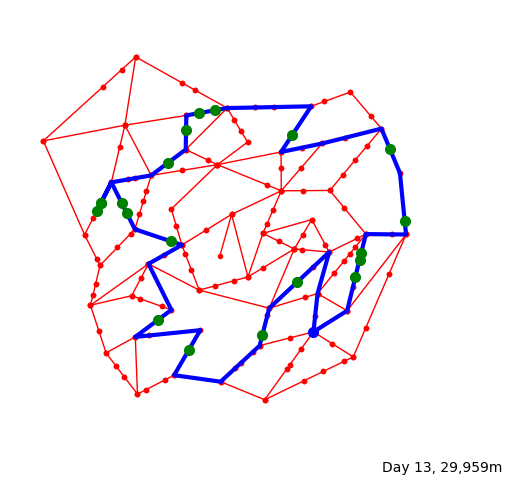

[13] 18:19:10.0 Driver leaves for delivery of 23 parcels
[13] 18:19:10.0 Driver drives to Customer: 99 (6174, 4088)
[13] 18:30:00.9 Driver arrived at Customer: 99 (6174, 4088)
[13] 18:31:13.3 Driver drives to Customer: 23 (5425, 2935)
[13] 18:36:56.0 Driver arrived at Customer: 23 (5425, 2935)
[13] 18:37:50.1 Driver drives to Customer:  8 (3850, 2629)
[13] 18:49:55.2 Driver arrived at Customer:  8 (3850, 2629)
[13] 18:52:51.8 Driver drives to Customer: 27 (3180, 3269)
[13] 19:02:50.2 Driver arrived at Customer: 27 (3180, 3269)
[13] 19:04:30.8 Driver drives to Customer:  2 (3460, 4972)
[13] 19:14:42.3 Driver arrived at Customer:  2 (3460, 4972)
[13] 19:15:28.1 Driver drives to Customer: 98 (2510, 5583)
[13] 19:20:18.0 Driver arrived at Customer: 98 (2510, 5583)
[13] 19:21:32.5 Driver drives to Customer: 90 (2399, 5807)
[13] 19:22:32.3 Driver arrived at Customer: 90 (2399, 5807)
[13] 19:23:22.9 Driver drives to Customer: 97 (1952, 5799)
[13] 19:27:21.7 Driver arrived at Customer: 97 (195

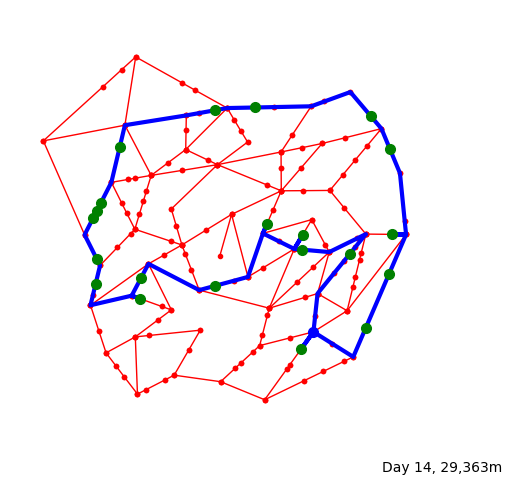

[14] 18:18:20.0 Driver leaves for delivery of 22 parcels
[14] 18:18:20.0 Driver drives to Customer: 81 (7308, 4700)
[14] 18:26:04.6 Driver arrived at Customer: 81 (7308, 4700)
[14] 18:26:42.4 Driver drives to Customer: 70 (6283, 4791)
[14] 18:34:45.1 Driver arrived at Customer: 70 (6283, 4791)
[14] 18:35:02.8 Driver drives to Customer:  6 (6292, 5109)
[14] 18:37:07.4 Driver arrived at Customer:  6 (6292, 5109)
[14] 18:37:18.9 Driver drives to Customer: 96 (5529, 5354)
[14] 18:42:38.6 Driver arrived at Customer: 96 (5529, 5354)
[14] 18:43:27.6 Driver drives to Customer: 49 (4399, 4005)
[14] 18:51:19.7 Driver arrived at Customer: 49 (4399, 4005)
[14] 18:52:12.7 Driver drives to Customer: 10 (2820, 4183)
[14] 18:59:51.4 Driver arrived at Customer: 10 (2820, 4183)
[14] 19:00:20.1 Driver drives to Customer: 71 (2801, 3728)
[14] 19:02:51.8 Driver arrived at Customer: 71 (2801, 3728)
[14] 19:04:46.3 Driver drives to Customer: 87 (1841, 4049)
[14] 19:11:04.7 Driver arrived at Customer: 87 (184

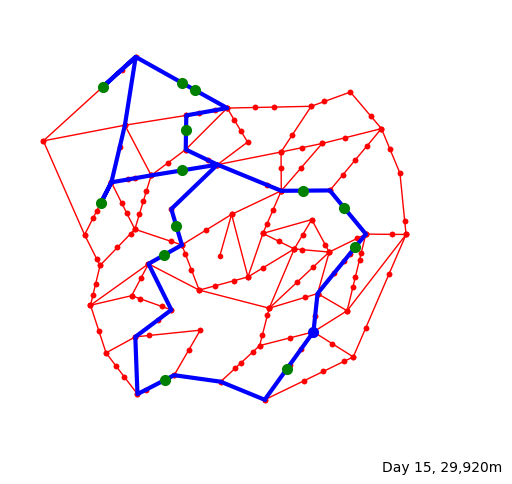

[15] 18:14:10.0 Driver leaves for delivery of 17 parcels
[15] 18:14:10.0 Driver drives to Customer: 18 (7422, 4842)
[15] 18:22:38.3 Driver arrived at Customer: 18 (7422, 4842)
[15] 18:23:03.6 Driver drives to Customer:  9 (7187, 5695)
[15] 18:27:27.6 Driver arrived at Customer:  9 (7187, 5695)
[15] 18:27:54.8 Driver drives to Customer: 63 (6294, 6068)
[15] 18:32:12.1 Driver arrived at Customer: 63 (6294, 6068)
[15] 18:33:28.3 Driver drives to Customer: 58 (3786, 7387)
[15] 18:45:59.1 Driver arrived at Customer: 58 (3786, 7387)
[15] 18:46:30.4 Driver drives to Customer: 93 (3975, 8246)
[15] 18:54:30.1 Driver arrived at Customer: 93 (3975, 8246)
[15] 18:54:57.8 Driver drives to Customer: 29 (3699, 8402)
[15] 18:56:13.9 Driver arrived at Customer: 29 (3699, 8402)
[15] 18:56:50.4 Driver drives to Customer: 28 (2001, 8320)
[15] 19:05:12.9 Driver arrived at Customer: 28 (2001, 8320)
[15] 19:06:35.4 Driver drives to Customer: 97 (1952, 5799)
[15] 19:23:28.2 Driver arrived at Customer: 97 (195

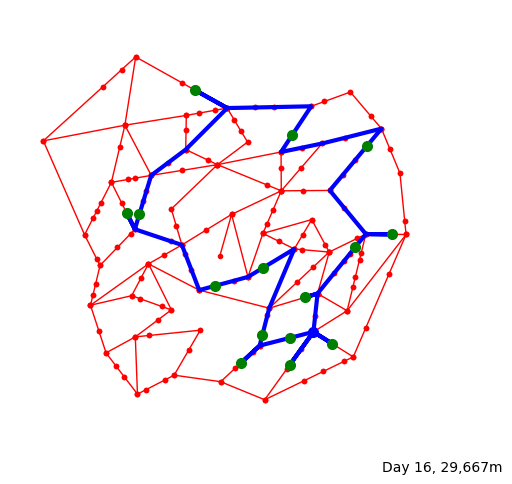

[16] 18:15:50.0 Driver leaves for delivery of 19 parcels
[16] 18:15:50.0 Driver drives to Customer: 95 (6018, 2300)
[16] 18:19:19.8 Driver arrived at Customer: 95 (6018, 2300)
[16] 18:20:56.8 Driver drives to Customer: 19 (6027, 2883)
[16] 18:26:30.2 Driver arrived at Customer: 19 (6027, 2883)
[16] 18:26:57.1 Driver drives to Customer: 39 (4968, 2341)
[16] 18:31:51.4 Driver arrived at Customer: 39 (4968, 2341)
[16] 18:32:49.7 Driver drives to Customer: 23 (5425, 2935)
[16] 18:35:55.4 Driver arrived at Customer: 23 (5425, 2935)
[16] 18:36:38.4 Driver drives to Customer: 89 (5445, 4400)
[16] 18:47:45.6 Driver arrived at Customer: 89 (5445, 4400)
[16] 18:49:11.0 Driver drives to Customer: 49 (4399, 4005)
[16] 18:53:41.3 Driver arrived at Customer: 49 (4399, 4005)
[16] 18:54:32.10 Driver drives to Customer: 98 (2510, 5583)
[16] 19:05:55.3 Driver arrived at Customer: 98 (2510, 5583)
[16] 19:06:59.4 Driver drives to Customer: 59 (2781, 5553)
[16] 19:09:53.4 Driver arrived at Customer: 59 (27

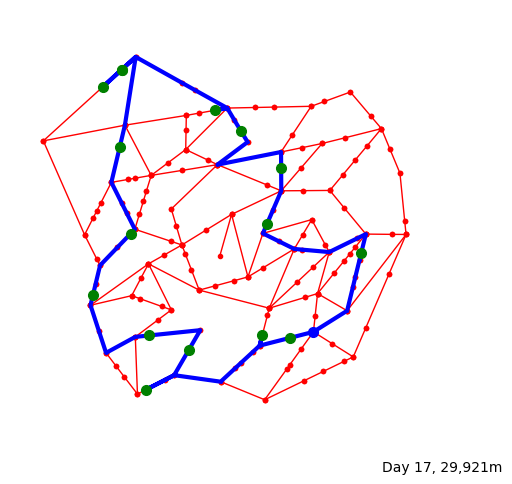

[17] 18:11:54.6 Parcel: 363 arr at delivery centre
[17] 18:19:10.0 Driver leaves for delivery of 23 parcels
[17] 18:19:10.0 Driver drives to Customer: 85 (7554, 4725)
[17] 18:27:45.0 Driver arrived at Customer: 85 (7554, 4725)
[17] 18:28:36.4 Driver drives to Customer: 96 (5529, 5354)
[17] 18:40:42.8 Driver arrived at Customer: 96 (5529, 5354)
[17] 18:42:38.3 Driver drives to Customer: 51 (5831, 6565)
[17] 18:47:43.8 Driver arrived at Customer: 51 (5831, 6565)
[17] 18:48:46.3 Driver drives to Customer: 48 (4961, 7367)
[17] 18:50:00.6 Parcel: 364 arr at delivery centre
[17] 19:00:06.7 Driver arrived at Customer: 48 (4961, 7367)
[17] 19:02:00.4 Driver drives to Customer:  7 (4400, 7807)
[17] 19:05:22.7 Driver arrived at Customer:  7 (4400, 7807)
[17] 19:06:15.0 Driver drives to Customer: 52 (2403, 8689)
[17] 19:08:02.8 Parcel: 365 arr at delivery centre
[17] 19:18:00.1 Driver arrived at Customer: 52 (2403, 8689)
[17] 19:21:04.2 Driver drives to Customer: 28 (2001, 8320)
[17] 19:23:14.10 

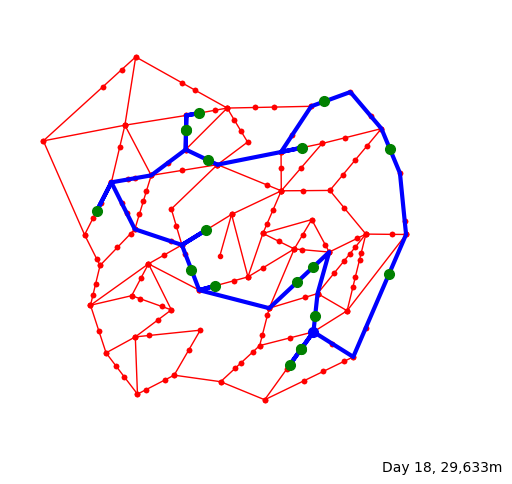

[18] 18:17:30.0 Driver leaves for delivery of 21 parcels
[18] 18:17:30.0 Driver drives to Customer: 42 (6254, 2631)
[18] 18:19:22.3 Driver arrived at Customer: 42 (6254, 2631)
[18] 18:20:55.10 Driver drives to Customer: 95 (6018, 2300)
[18] 18:22:33.4 Driver arrived at Customer: 95 (6018, 2300)
[18] 18:24:03.9 Driver drives to Customer: 42 (6254, 2631)
[18] 18:25:41.3 Driver arrived at Customer: 42 (6254, 2631)
[18] 18:27:42.1 Driver drives to Customer: 84 (8147, 4255)
[18] 18:41:23.2 Driver arrived at Customer: 84 (8147, 4255)
[18] 18:43:07.3 Driver drives to Customer: 33 (8170, 6969)
[18] 18:54:28.5 Driver arrived at Customer: 33 (8170, 6969)
[18] 18:55:20.6 Driver drives to Customer: 24 (6761, 7998)
[18] 19:03:46.5 Driver arrived at Customer: 24 (6761, 7998)
[18] 19:04:08.9 Driver drives to Customer: 11 (6279, 6998)
[18] 19:11:55.2 Driver arrived at Customer: 11 (6279, 6998)
[18] 19:12:44.9 Driver drives to Customer: 32 (4250, 6732)
[18] 19:21:05.8 Driver arrived at Customer: 32 (42

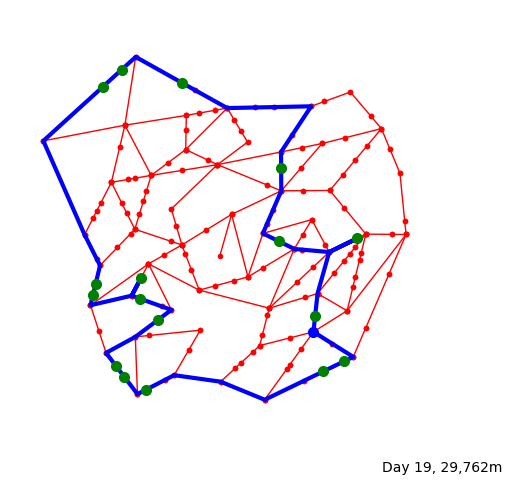

[19] 18:15:00.0 Driver leaves for delivery of 18 parcels
[19] 18:15:00.0 Driver drives to Customer: 17 (6563, 3364)
[19] 18:16:24.7 Driver arrived at Customer: 17 (6563, 3364)
[19] 18:17:18.2 Driver drives to Customer: 69 (7462, 5033)
[19] 18:25:36.5 Driver arrived at Customer: 69 (7462, 5033)
[19] 18:26:58.3 Driver drives to Customer:  5 (5785, 4970)
[19] 18:34:06.7 Driver arrived at Customer:  5 (5785, 4970)
[19] 18:35:35.0 Driver drives to Customer: 51 (5831, 6565)
[19] 18:43:08.2 Driver arrived at Customer: 51 (5831, 6565)
[19] 18:43:29.2 Driver drives to Customer: 29 (3699, 8402)
[19] 19:01:15.3 Driver arrived at Customer: 29 (3699, 8402)
[19] 19:01:39.6 Driver drives to Customer: 52 (2403, 8689)
[19] 19:07:51.3 Driver arrived at Customer: 52 (2403, 8689)
[19] 19:10:00.0 Driver drives to Customer: 28 (2001, 8320)
[19] 19:12:10.8 Driver arrived at Customer: 28 (2001, 8320)
[19] 19:12:25.2 Driver drives to Customer: 87 (1841, 4049)
[19] 19:32:51.6 Driver arrived at Customer: 87 (184

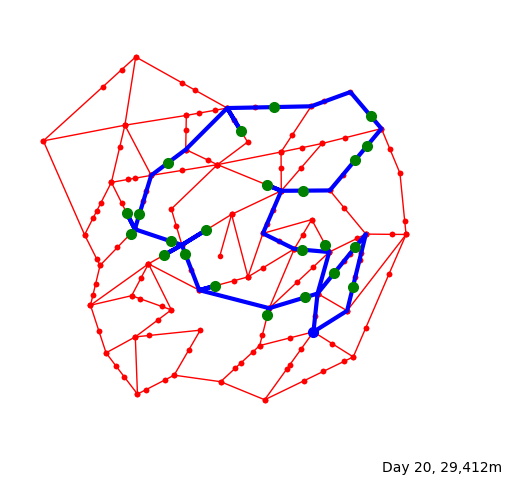

[20] 18:25:00.0 Driver leaves for delivery of 30 parcels
[20] 18:25:00.0 Driver drives to Customer: 37 (6784, 4889)
[20] 18:32:44.2 Driver arrived at Customer: 37 (6784, 4889)
[20] 18:33:17.8 Driver drives to Customer: 70 (6283, 4791)
[20] 18:36:18.8 Driver arrived at Customer: 70 (6283, 4791)
[20] 18:37:24.8 Driver drives to Customer: 36 (5535, 6188)
[20] 18:46:24.1 Driver arrived at Customer: 36 (5535, 6188)
[20] 18:49:30.6 Driver drives to Customer: 63 (6294, 6068)
[20] 18:52:38.5 Driver arrived at Customer: 63 (6294, 6068)
[20] 18:53:20.5 Driver drives to Customer: 50 (7428, 6736)
[20] 18:59:07.3 Driver arrived at Customer: 50 (7428, 6736)
[20] 18:59:37.1 Driver drives to Customer: 53 (7669, 7026)
[20] 19:01:07.6 Driver arrived at Customer: 53 (7669, 7026)
[20] 19:02:33.6 Driver drives to Customer: 77 (7757, 7684)
[20] 19:05:59.1 Driver arrived at Customer: 77 (7757, 7684)
[20] 19:06:36.10 Driver drives to Customer: 21 (5685, 7877)
[20] 19:16:05.1 Driver arrived at Customer: 21 (56

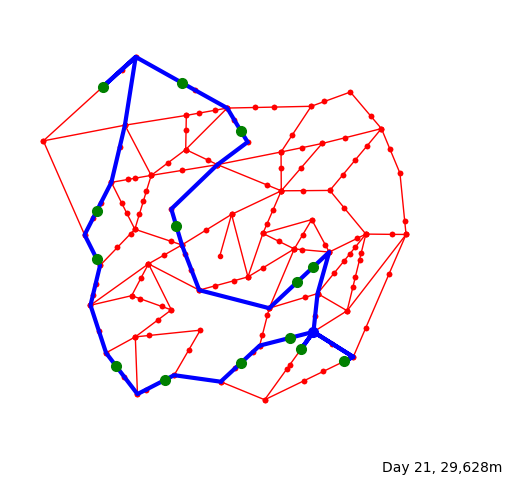

[21] 18:13:20.0 Driver leaves for delivery of 16 parcels
[21] 18:13:20.0 Driver drives to Customer: 64 (7193, 2378)
[21] 18:18:13.3 Driver arrived at Customer: 64 (7193, 2378)
[21] 18:18:47.1 Driver drives to Customer: 19 (6027, 2883)
[21] 18:25:43.10 Driver arrived at Customer: 19 (6027, 2883)
[21] 18:26:15.3 Driver drives to Customer: 39 (4968, 2341)
[21] 18:31:09.6 Driver arrived at Customer: 39 (4968, 2341)
[21] 18:32:30.7 Driver drives to Customer: 14 (3334, 1972)
[21] 18:39:49.1 Driver arrived at Customer: 14 (3334, 1972)
[21] 18:41:51.6 Driver drives to Customer: 73 (2287, 2263)
[21] 18:47:31.7 Driver arrived at Customer: 73 (2287, 2263)
[21] 18:47:51.6 Driver drives to Customer: 57 (1862, 4597)
[21] 18:57:51.6 Driver arrived at Customer: 57 (1862, 4597)
[21] 18:58:23.7 Driver drives to Customer:  1 (1868, 5634)
[21] 19:03:01.9 Driver arrived at Customer:  1 (1868, 5634)
[21] 19:03:33.6 Driver drives to Customer: 28 (2001, 8320)
[21] 19:21:10.8 Driver arrived at Customer: 28 (20

In [27]:
random.seed(0)
rec17 = simulation(M17, W17, C17, D17, log=True, plot=True)

## Adding Statistics and Visualisation

In [28]:
rec17.daily

,driver_starts,driver_ends,distance,leftover,time
0,64800,74527,29.991,6,162.116667
1,151200,160282,29.997,13,151.366667
2,237600,247450,29.964,11,164.166667
3,324000,334205,29.94,7,170.083333
4,410400,420240,29.998,6,164.0
5,496800,506424,29.812,16,160.4
6,583200,592995,29.779,13,163.25
7,669600,679781,29.555,7,169.683333
8,756000,765240,29.943,10,154.0
9,842400,852583,29.978,3,169.716667


In [29]:
def makePlot(df_attribute, title, xlabel, ylabel):
    fig, ax=plt.subplots(1,1)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.plot(df_attribute, color ='red', marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.grid(True)
    plt.show()

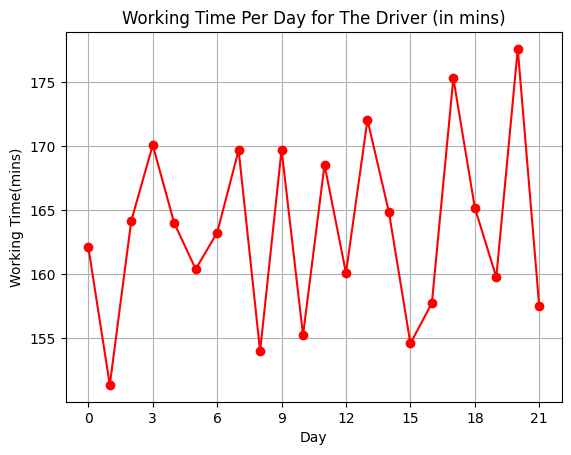

In [30]:
# Working time per day for the driver (in mins)
makePlot(rec17.daily['time'],
         'Working Time Per Day for The Driver (in mins)',
         'Day', 'Working Time(mins)')

In [31]:
min(rec17.daily['time'])

151.36666666666667

In [32]:
max(rec17.daily['time'])

177.58333333333334

In [33]:
np.mean(rec17.daily['time'])

163.51363636363638

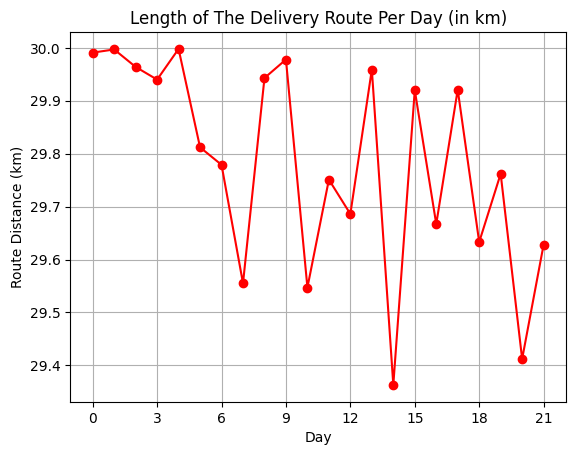

In [34]:
# length of the delivery route per day (in km)
makePlot(rec17.daily['distance'], 
         'Length of The Delivery Route Per Day (in km)',
         'Day', 'Route Distance (km)')

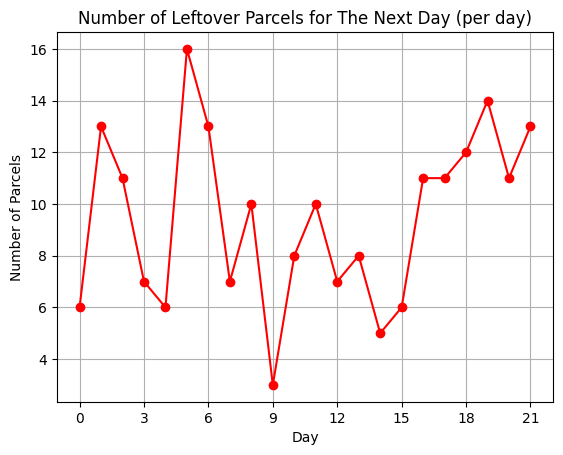

In [35]:
# Number of leftover parcels for the next day (per day)
makePlot(rec17.daily['leftover'],
         'Number of Leftover Parcels for The Next Day (per day)',
         'Day', 'Number of Parcels')

In [36]:
rec17.perParcel

,arrived,accepted,delay
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
443,21.0,21.0,0.0
444,21.0,21.0,0.0
445,21.0,NaN,NaN
446,21.0,NaN,NaN


In [37]:
import collections
# using Counter to find frequency of elements
frequency = collections.Counter(rec17.perParcel['accepted'])
# printing the frequency
realAccepted=list(dict(frequency).values())[:22]
print(realAccepted)
print(max(realAccepted))
print(min(realAccepted))
print(int(np.mean(realAccepted)))

[16, 12, 21, 27, 21, 17, 21, 25, 14, 23, 14, 19, 20, 22, 22, 17, 19, 22, 19, 18, 30, 16]
30
12
19


In [38]:
rec17.perParcel.to_csv('ParcelDelay.csv')

There are 430 parcels have been delivered in 21 days.


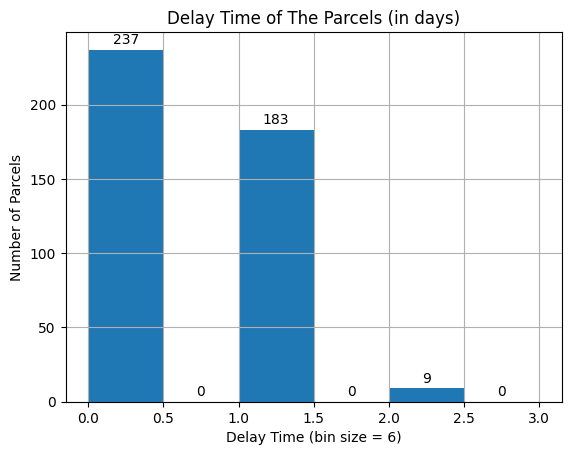

In [39]:
# Delay time of the parcels (in days)
data = rec17.perParcel['delay']
bins = 6 # fixed bin size
fig, ax=plt.subplots(1,1)
i = 0
for day in rec17.perParcel['arrived']:
    if day <= 20:
        i+=1
    else: break
print('There are '+str(i)+' parcels have been delivered in 21 days.')        
# The range indicates delay time from 0 day to 3 days
plt.hist(rec17.perParcel['delay'][:i], bins=bins, range =[0,3])
plt.title('Delay Time of The Parcels (in days)')
plt.xlabel('Delay Time (bin size = 6)')
plt.ylabel('Number of Parcels')
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0,2), textcoords='offset points', ha='center', va='bottom') 
ax.grid(True)
plt.show()